# Looking for a representation of tempo in the data

In [3]:
# Cell 1: Import Libraries
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


## 2. Define Preprocessing Steps
1. Normalize
2. Create 3. Sek. Chunks to analyse, and use it for overlapping
3. Estimate the speed

In [4]:

def normalize_loudness(y):
    """Normalize audio to have consistent loudness."""
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y / rms
    return y

def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    # Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    # Normalize loudness
    y = normalize_loudness(y)
    return y

def segment_audio(y, sr, segment_length=3.0, hop_length=1.0):
    """Segment audio into overlapping chunks."""
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segments.append(y[start:end])
    return segments

def estimate_tempo(y, sr=16000):
    """Estimate the tempo of an audio signal."""
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr, trim=False)
        if tempo == 0:
            tempo = np.nan  # Handle zero tempo
    except Exception as e:
        print(f"Error estimating tempo: {e}")
        tempo = np.nan
    return tempo


## Load and process Audio Files
Audiofiles are loaded and processed in the following way: Resample to 16kHz, normalize to 0dB, and convert to mono. Segments are extracted from the audio files. The Segments are 3 seconds long and overlap by 1 second.

In [5]:
# Cell 3: Load and Process Audio Files

# Path to your dataset folder
dataset_path = '../dataset'

# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio segments and tempo labels
audio_segments = []
tempo_labels = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    segments = segment_audio(y, sr=16000, segment_length=3.0, hop_length=1.0)
    for segment in segments:
        # Estimate tempo for each segment
        tempo = estimate_tempo(segment)
        audio_segments.append(segment)
        tempo_labels.append(tempo)

# Convert tempo_labels to a NumPy array
tempo_labels = np.array(tempo_labels)

# Identify valid indices where tempo is not NaN
valid_indices = ~np.isnan(tempo_labels)

# Filter the audio_segments and tempo_labels
audio_segments = [audio_segments[i] for i in range(len(audio_segments)) if valid_indices[i]]
tempo_labels = tempo_labels[valid_indices]


Loading and preprocessing audio files:   0%|          | 0/615 [00:00<?, ?it/s]

## Cell 4: Define Feature Extraction Function

In [6]:


def extract_features(y, sr=16000):
    """Extract various audio features."""
    # Tempogram features
    oenv = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
    tempogram_mean = np.mean(tempogram, axis=1)
    
    # MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)
    
    # Concatenate all features
    features = np.concatenate((tempogram_mean, mfcc_mean, chroma_mean, contrast_mean))
    return features




## Cell 5: Extract Features from All Segments

In [7]:


# Extract features for all segments
feature_vectors = []

for y in tqdm(audio_segments, desc='Extracting features'):
    features = extract_features(y)
    feature_vectors.append(features)

# Convert feature_vectors to a NumPy array
feature_vectors = np.array(feature_vectors)


Extracting features:   0%|          | 0/5638 [00:00<?, ?it/s]

## Cell 6: Normalize Features

In [8]:


# Normalize features
feature_mean = np.mean(feature_vectors, axis=0)
feature_std = np.std(feature_vectors, axis=0)
feature_std[feature_std == 0] = 1e-6  # Avoid division by zero
feature_vectors_normalized = (feature_vectors - feature_mean) / feature_std

# Add a print statement to confirm variable creation
print("Feature vectors normalized shape:", feature_vectors_normalized.shape)


Feature vectors normalized shape: (5638, 416)


## Cell 7: Normalize Tempo Labels


In [11]:

# Compute the maximum tempo value
max_tempo = np.max(tempo_labels)

# Normalize tempo labels
tempo_labels_normalized = tempo_labels / max_tempo


## Cell 8: Create a Custom Dataset


In [26]:

from torch.utils.data import Dataset, DataLoader

class TempoDataset(Dataset):
    def __init__(self, feature_vectors, tempo_labels):
        self.feature_vectors = torch.tensor(feature_vectors).float()
        self.tempo_labels = torch.tensor(tempo_labels).float()

    def __len__(self):
        return len(self.feature_vectors)

    def __getitem__(self, idx):
        return self.feature_vectors[idx], self.tempo_labels[idx]


## Cell 9: Split Dataset


In [77]:

from sklearn.model_selection import train_test_split

# Use normalized features and labels
train_features, val_features, train_labels, val_labels = train_test_split(
    feature_vectors_normalized, tempo_labels_normalized, test_size=0.2, random_state=42)



## Cell 10: Create DataLoaders

Create DataLoaders

In [78]:
train_dataset = TempoDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TempoDataset(val_features, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Cell 11: Define the Regression Model
This network is designed to predict a tempo value (or a related feature) from the input data.


# Layers
1.  Fully Connected Layer (fc1): The first layer takes the input data (with input_size features) and maps it to hidden_size neurons.
2. ReLU Activation: Applies the Rectified Linear Unit (ReLU) activation, which introduces non-linearity, helping the network learn complex patterns.
3.  Dropout: Applies dropout regularization to prevent overfitting.
4. Second Fully Connected Layer (fc2): Reduces the number of neurons to half of the previous layer (hidden_size // 2), which helps in further feature extraction.
5. Output Layer (fc3): Maps the reduced hidden layer to a single output neuron, representing the predicted tempo.

The TempoRegressor is a feedforward neural network designed for regression tasks. It consists of three fully connected layers with ReLU activations and dropout for regularization. The sigmoid activation at the output ensures that the predicted value is in a normalized range. This architecture can effectively map input features (like audio characteristics) to a continuous value (e.g., tempo).


In [79]:

import torch.nn as nn

class TempoRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TempoRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.sigmoid = nn.Sigmoid()  # Output between 0 and 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x.squeeze()


# Cell 12: Initialize the Model

In [80]:


# Define input_size and hidden_size based on the new feature vector size
input_size = feature_vectors_normalized.shape[1]  # Number of features
hidden_size = 128  # Adjusted hidden size

model = TempoRegressor(input_size, hidden_size)


## Cell 13: Define Loss Function and Optimizer

1. nn.L1Loss(): Calculates the Mean Absolute Error (MAE), which is less sensitive to outliers than MSE and provides a clear measure of average error.
optim.
2. Adam: The Adam optimizer with a learning rate of 0.0001 is chosen for its adaptive learning capabilities and to ensure smooth, stable training. Reducing the learning rate helps the model make smaller, precise adjustments during weight updates, improving overall performance.

In [81]:


import torch.optim as optim

criterion = nn.L1Loss()  # Using Mean Absolute Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate


## !!!!! OPTIONAL !!!! 


Resume Training form a previously saved model. (This means you need to run step 7 at least one time before)




In [49]:
# Cell Before: Load the Best Model

import torch

# Ensure the model class TempoRegressor is defined
# and input_size, hidden_size are set

# Initialize the model
model = TempoRegressor(input_size, hidden_size)
model.to(device)

# Load the best model
checkpoint_dir = 'checkpoints_05'  # Update as needed
best_model_path = os.path.join(checkpoint_dir, 'best_tempo_model.pth')
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

print("Best model loaded successfully for evaluation.")


Best model loaded successfully for evaluation.


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_16769/1124066247.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

## Cell 14: Train the Model


Epoch 1/1000: 100%|██████████| 141/141 [00:00<00:00, 1453.70it/s]


Epoch [1/1000], Train Loss: 0.0999, Val Loss: 0.0920
Best model saved with validation loss: 0.0920


Epoch 2/1000: 100%|██████████| 141/141 [00:00<00:00, 1504.13it/s]


Epoch [2/1000], Train Loss: 0.0944, Val Loss: 0.0942
No improvement in validation loss for 1 epoch(s).


Epoch 3/1000: 100%|██████████| 141/141 [00:00<00:00, 1534.41it/s]


Epoch [3/1000], Train Loss: 0.0916, Val Loss: 0.0874
Best model saved with validation loss: 0.0874


Epoch 4/1000: 100%|██████████| 141/141 [00:00<00:00, 1441.53it/s]


Epoch [4/1000], Train Loss: 0.0886, Val Loss: 0.0838
Best model saved with validation loss: 0.0838


Epoch 5/1000: 100%|██████████| 141/141 [00:00<00:00, 1578.73it/s]


Epoch [5/1000], Train Loss: 0.0873, Val Loss: 0.0846
No improvement in validation loss for 1 epoch(s).


Epoch 6/1000: 100%|██████████| 141/141 [00:00<00:00, 1211.26it/s]


Epoch [6/1000], Train Loss: 0.0856, Val Loss: 0.0829
Best model saved with validation loss: 0.0829


Epoch 7/1000: 100%|██████████| 141/141 [00:00<00:00, 1623.27it/s]


Epoch [7/1000], Train Loss: 0.0854, Val Loss: 0.0852
No improvement in validation loss for 1 epoch(s).


Epoch 8/1000: 100%|██████████| 141/141 [00:00<00:00, 1623.66it/s]


Epoch [8/1000], Train Loss: 0.0845, Val Loss: 0.0828
Best model saved with validation loss: 0.0828


Epoch 9/1000: 100%|██████████| 141/141 [00:00<00:00, 1636.66it/s]


Epoch [9/1000], Train Loss: 0.0834, Val Loss: 0.0814
Best model saved with validation loss: 0.0814


Epoch 10/1000: 100%|██████████| 141/141 [00:00<00:00, 1622.99it/s]


Epoch [10/1000], Train Loss: 0.0831, Val Loss: 0.0810
Best model saved with validation loss: 0.0810


Epoch 11/1000: 100%|██████████| 141/141 [00:00<00:00, 1554.85it/s]


Epoch [11/1000], Train Loss: 0.0820, Val Loss: 0.0802
Best model saved with validation loss: 0.0802


Epoch 12/1000: 100%|██████████| 141/141 [00:00<00:00, 1570.43it/s]


Epoch [12/1000], Train Loss: 0.0827, Val Loss: 0.0815
No improvement in validation loss for 1 epoch(s).


Epoch 13/1000: 100%|██████████| 141/141 [00:00<00:00, 1497.88it/s]


Epoch [13/1000], Train Loss: 0.0820, Val Loss: 0.0812
No improvement in validation loss for 2 epoch(s).


Epoch 14/1000: 100%|██████████| 141/141 [00:00<00:00, 1513.17it/s]


Epoch [14/1000], Train Loss: 0.0822, Val Loss: 0.0820
No improvement in validation loss for 3 epoch(s).


Epoch 15/1000: 100%|██████████| 141/141 [00:00<00:00, 1581.23it/s]


Epoch [15/1000], Train Loss: 0.0821, Val Loss: 0.0805
No improvement in validation loss for 4 epoch(s).


Epoch 16/1000: 100%|██████████| 141/141 [00:00<00:00, 1602.49it/s]


Epoch [16/1000], Train Loss: 0.0809, Val Loss: 0.0803
No improvement in validation loss for 5 epoch(s).


Epoch 17/1000: 100%|██████████| 141/141 [00:00<00:00, 1206.85it/s]


Epoch [17/1000], Train Loss: 0.0804, Val Loss: 0.0810
No improvement in validation loss for 6 epoch(s).


Epoch 18/1000: 100%|██████████| 141/141 [00:00<00:00, 1471.28it/s]


Epoch [18/1000], Train Loss: 0.0806, Val Loss: 0.0786
Best model saved with validation loss: 0.0786


Epoch 19/1000: 100%|██████████| 141/141 [00:00<00:00, 1558.29it/s]


Epoch [19/1000], Train Loss: 0.0806, Val Loss: 0.0811
No improvement in validation loss for 1 epoch(s).


Epoch 20/1000: 100%|██████████| 141/141 [00:00<00:00, 1614.88it/s]


Epoch [20/1000], Train Loss: 0.0800, Val Loss: 0.0798
No improvement in validation loss for 2 epoch(s).


Epoch 21/1000: 100%|██████████| 141/141 [00:00<00:00, 1602.98it/s]


Epoch [21/1000], Train Loss: 0.0796, Val Loss: 0.0796
No improvement in validation loss for 3 epoch(s).


Epoch 22/1000: 100%|██████████| 141/141 [00:00<00:00, 1609.80it/s]


Epoch [22/1000], Train Loss: 0.0800, Val Loss: 0.0787
No improvement in validation loss for 4 epoch(s).


Epoch 23/1000: 100%|██████████| 141/141 [00:00<00:00, 1433.48it/s]


Epoch [23/1000], Train Loss: 0.0801, Val Loss: 0.0782
Best model saved with validation loss: 0.0782


Epoch 24/1000: 100%|██████████| 141/141 [00:00<00:00, 1600.09it/s]


Epoch [24/1000], Train Loss: 0.0794, Val Loss: 0.0784
No improvement in validation loss for 1 epoch(s).


Epoch 25/1000: 100%|██████████| 141/141 [00:00<00:00, 1612.50it/s]


Epoch [25/1000], Train Loss: 0.0792, Val Loss: 0.0792
No improvement in validation loss for 2 epoch(s).


Epoch 26/1000: 100%|██████████| 141/141 [00:00<00:00, 1606.75it/s]


Epoch [26/1000], Train Loss: 0.0791, Val Loss: 0.0790
No improvement in validation loss for 3 epoch(s).


Epoch 27/1000: 100%|██████████| 141/141 [00:00<00:00, 1218.15it/s]


Epoch [27/1000], Train Loss: 0.0788, Val Loss: 0.0788
No improvement in validation loss for 4 epoch(s).


Epoch 28/1000: 100%|██████████| 141/141 [00:00<00:00, 1503.53it/s]


Epoch [28/1000], Train Loss: 0.0787, Val Loss: 0.0805
No improvement in validation loss for 5 epoch(s).


Epoch 29/1000: 100%|██████████| 141/141 [00:00<00:00, 1460.29it/s]


Epoch [29/1000], Train Loss: 0.0786, Val Loss: 0.0780
Best model saved with validation loss: 0.0780


Epoch 30/1000: 100%|██████████| 141/141 [00:00<00:00, 1610.40it/s]


Epoch [30/1000], Train Loss: 0.0793, Val Loss: 0.0783
No improvement in validation loss for 1 epoch(s).


Epoch 31/1000: 100%|██████████| 141/141 [00:00<00:00, 1594.14it/s]


Epoch [31/1000], Train Loss: 0.0783, Val Loss: 0.0785
No improvement in validation loss for 2 epoch(s).


Epoch 32/1000: 100%|██████████| 141/141 [00:00<00:00, 1610.27it/s]


Epoch [32/1000], Train Loss: 0.0783, Val Loss: 0.0781
No improvement in validation loss for 3 epoch(s).


Epoch 33/1000: 100%|██████████| 141/141 [00:00<00:00, 1607.97it/s]


Epoch [33/1000], Train Loss: 0.0775, Val Loss: 0.0775
Best model saved with validation loss: 0.0775


Epoch 34/1000: 100%|██████████| 141/141 [00:00<00:00, 1534.27it/s]


Epoch [34/1000], Train Loss: 0.0779, Val Loss: 0.0770
Best model saved with validation loss: 0.0770


Epoch 35/1000: 100%|██████████| 141/141 [00:00<00:00, 1599.60it/s]


Epoch [35/1000], Train Loss: 0.0781, Val Loss: 0.0779
No improvement in validation loss for 1 epoch(s).


Epoch 36/1000: 100%|██████████| 141/141 [00:00<00:00, 1589.75it/s]


Epoch [36/1000], Train Loss: 0.0771, Val Loss: 0.0766
Best model saved with validation loss: 0.0766


Epoch 37/1000: 100%|██████████| 141/141 [00:00<00:00, 1611.06it/s]


Epoch [37/1000], Train Loss: 0.0773, Val Loss: 0.0773
No improvement in validation loss for 1 epoch(s).


Epoch 38/1000: 100%|██████████| 141/141 [00:00<00:00, 1210.79it/s]


Epoch [38/1000], Train Loss: 0.0781, Val Loss: 0.0773
No improvement in validation loss for 2 epoch(s).


Epoch 39/1000: 100%|██████████| 141/141 [00:00<00:00, 1512.81it/s]


Epoch [39/1000], Train Loss: 0.0774, Val Loss: 0.0768
No improvement in validation loss for 3 epoch(s).


Epoch 40/1000: 100%|██████████| 141/141 [00:00<00:00, 1560.50it/s]


Epoch [40/1000], Train Loss: 0.0772, Val Loss: 0.0779
No improvement in validation loss for 4 epoch(s).


Epoch 41/1000: 100%|██████████| 141/141 [00:00<00:00, 1567.92it/s]


Epoch [41/1000], Train Loss: 0.0774, Val Loss: 0.0777
No improvement in validation loss for 5 epoch(s).


Epoch 42/1000: 100%|██████████| 141/141 [00:00<00:00, 1558.75it/s]


Epoch [42/1000], Train Loss: 0.0771, Val Loss: 0.0775
No improvement in validation loss for 6 epoch(s).


Epoch 43/1000: 100%|██████████| 141/141 [00:00<00:00, 1608.76it/s]


Epoch [43/1000], Train Loss: 0.0767, Val Loss: 0.0773
No improvement in validation loss for 7 epoch(s).


Epoch 44/1000: 100%|██████████| 141/141 [00:00<00:00, 1576.46it/s]


Epoch [44/1000], Train Loss: 0.0770, Val Loss: 0.0771
No improvement in validation loss for 8 epoch(s).


Epoch 45/1000: 100%|██████████| 141/141 [00:00<00:00, 1541.56it/s]


Epoch [45/1000], Train Loss: 0.0760, Val Loss: 0.0773
No improvement in validation loss for 9 epoch(s).


Epoch 46/1000: 100%|██████████| 141/141 [00:00<00:00, 1447.64it/s]


Epoch [46/1000], Train Loss: 0.0757, Val Loss: 0.0764
Best model saved with validation loss: 0.0764


Epoch 47/1000: 100%|██████████| 141/141 [00:00<00:00, 1613.16it/s]


Epoch [47/1000], Train Loss: 0.0757, Val Loss: 0.0767
No improvement in validation loss for 1 epoch(s).


Epoch 48/1000: 100%|██████████| 141/141 [00:00<00:00, 1614.19it/s]


Epoch [48/1000], Train Loss: 0.0755, Val Loss: 0.0775
No improvement in validation loss for 2 epoch(s).


Epoch 49/1000: 100%|██████████| 141/141 [00:00<00:00, 1221.13it/s]


Epoch [49/1000], Train Loss: 0.0760, Val Loss: 0.0770
No improvement in validation loss for 3 epoch(s).


Epoch 50/1000: 100%|██████████| 141/141 [00:00<00:00, 1594.75it/s]


Epoch [50/1000], Train Loss: 0.0746, Val Loss: 0.0765
No improvement in validation loss for 4 epoch(s).


Epoch 51/1000: 100%|██████████| 141/141 [00:00<00:00, 1591.42it/s]


Epoch [51/1000], Train Loss: 0.0757, Val Loss: 0.0773
No improvement in validation loss for 5 epoch(s).


Epoch 52/1000: 100%|██████████| 141/141 [00:00<00:00, 1604.83it/s]


Epoch [52/1000], Train Loss: 0.0754, Val Loss: 0.0764
Best model saved with validation loss: 0.0764


Epoch 53/1000: 100%|██████████| 141/141 [00:00<00:00, 1605.10it/s]


Epoch [53/1000], Train Loss: 0.0751, Val Loss: 0.0779
No improvement in validation loss for 1 epoch(s).


Epoch 54/1000: 100%|██████████| 141/141 [00:00<00:00, 1611.47it/s]


Epoch [54/1000], Train Loss: 0.0761, Val Loss: 0.0768
No improvement in validation loss for 2 epoch(s).


Epoch 55/1000: 100%|██████████| 141/141 [00:00<00:00, 1602.97it/s]


Epoch [55/1000], Train Loss: 0.0753, Val Loss: 0.0770
No improvement in validation loss for 3 epoch(s).


Epoch 56/1000: 100%|██████████| 141/141 [00:00<00:00, 1544.32it/s]


Epoch [56/1000], Train Loss: 0.0752, Val Loss: 0.0772
No improvement in validation loss for 4 epoch(s).


Epoch 57/1000: 100%|██████████| 141/141 [00:00<00:00, 1549.08it/s]


Epoch [57/1000], Train Loss: 0.0745, Val Loss: 0.0760
Best model saved with validation loss: 0.0760


Epoch 58/1000: 100%|██████████| 141/141 [00:00<00:00, 1569.46it/s]


Epoch [58/1000], Train Loss: 0.0743, Val Loss: 0.0754
Best model saved with validation loss: 0.0754


Epoch 59/1000: 100%|██████████| 141/141 [00:00<00:00, 1600.20it/s]


Epoch [59/1000], Train Loss: 0.0748, Val Loss: 0.0771
No improvement in validation loss for 1 epoch(s).


Epoch 60/1000: 100%|██████████| 141/141 [00:00<00:00, 1210.29it/s]


Epoch [60/1000], Train Loss: 0.0743, Val Loss: 0.0760
No improvement in validation loss for 2 epoch(s).


Epoch 61/1000: 100%|██████████| 141/141 [00:00<00:00, 1577.02it/s]


Epoch [61/1000], Train Loss: 0.0743, Val Loss: 0.0760
No improvement in validation loss for 3 epoch(s).


Epoch 62/1000: 100%|██████████| 141/141 [00:00<00:00, 1610.01it/s]


Epoch [62/1000], Train Loss: 0.0743, Val Loss: 0.0761
No improvement in validation loss for 4 epoch(s).


Epoch 63/1000: 100%|██████████| 141/141 [00:00<00:00, 1608.07it/s]


Epoch [63/1000], Train Loss: 0.0737, Val Loss: 0.0760
No improvement in validation loss for 5 epoch(s).


Epoch 64/1000: 100%|██████████| 141/141 [00:00<00:00, 1583.52it/s]


Epoch [64/1000], Train Loss: 0.0743, Val Loss: 0.0760
No improvement in validation loss for 6 epoch(s).


Epoch 65/1000: 100%|██████████| 141/141 [00:00<00:00, 1570.75it/s]


Epoch [65/1000], Train Loss: 0.0740, Val Loss: 0.0762
No improvement in validation loss for 7 epoch(s).


Epoch 66/1000: 100%|██████████| 141/141 [00:00<00:00, 1485.84it/s]

Epoch [66/1000], Train Loss: 0.0738, Val Loss: 0.0755


No improvement in validation loss for 8 epoch(s).


Epoch 67/1000: 100%|██████████| 141/141 [00:00<00:00, 1577.13it/s]

Epoch [67/1000], Train Loss: 0.0736, Val Loss: 0.0752


Best model saved with validation loss: 0.0752


Epoch 68/1000: 100%|██████████| 141/141 [00:00<00:00, 1587.77it/s]


Epoch [68/1000], Train Loss: 0.0733, Val Loss: 0.0761
No improvement in validation loss for 1 epoch(s).


Epoch 69/1000: 100%|██████████| 141/141 [00:00<00:00, 1606.84it/s]


Epoch [69/1000], Train Loss: 0.0727, Val Loss: 0.0756
No improvement in validation loss for 2 epoch(s).


Epoch 70/1000: 100%|██████████| 141/141 [00:00<00:00, 1608.78it/s]


Epoch [70/1000], Train Loss: 0.0733, Val Loss: 0.0759
No improvement in validation loss for 3 epoch(s).


Epoch 71/1000: 100%|██████████| 141/141 [00:00<00:00, 1113.90it/s]


Epoch [71/1000], Train Loss: 0.0740, Val Loss: 0.0754
No improvement in validation loss for 4 epoch(s).


Epoch 72/1000: 100%|██████████| 141/141 [00:00<00:00, 1602.07it/s]


Epoch [72/1000], Train Loss: 0.0727, Val Loss: 0.0768
No improvement in validation loss for 5 epoch(s).


Epoch 73/1000: 100%|██████████| 141/141 [00:00<00:00, 1600.11it/s]


Epoch [73/1000], Train Loss: 0.0727, Val Loss: 0.0754
No improvement in validation loss for 6 epoch(s).


Epoch 74/1000: 100%|██████████| 141/141 [00:00<00:00, 1594.14it/s]


Epoch [74/1000], Train Loss: 0.0721, Val Loss: 0.0771
No improvement in validation loss for 7 epoch(s).


Epoch 75/1000: 100%|██████████| 141/141 [00:00<00:00, 1498.77it/s]


Epoch [75/1000], Train Loss: 0.0717, Val Loss: 0.0750
Best model saved with validation loss: 0.0750


Epoch 76/1000: 100%|██████████| 141/141 [00:00<00:00, 1570.60it/s]


Epoch [76/1000], Train Loss: 0.0720, Val Loss: 0.0751
No improvement in validation loss for 1 epoch(s).


Epoch 77/1000: 100%|██████████| 141/141 [00:00<00:00, 1589.31it/s]


Epoch [77/1000], Train Loss: 0.0721, Val Loss: 0.0747
Best model saved with validation loss: 0.0747


Epoch 78/1000: 100%|██████████| 141/141 [00:00<00:00, 1616.70it/s]


Epoch [78/1000], Train Loss: 0.0721, Val Loss: 0.0754
No improvement in validation loss for 1 epoch(s).


Epoch 79/1000: 100%|██████████| 141/141 [00:00<00:00, 1599.01it/s]


Epoch [79/1000], Train Loss: 0.0719, Val Loss: 0.0756
No improvement in validation loss for 2 epoch(s).


Epoch 80/1000: 100%|██████████| 141/141 [00:00<00:00, 1582.67it/s]


Epoch [80/1000], Train Loss: 0.0724, Val Loss: 0.0748
No improvement in validation loss for 3 epoch(s).


Epoch 81/1000: 100%|██████████| 141/141 [00:00<00:00, 1532.02it/s]


Epoch [81/1000], Train Loss: 0.0723, Val Loss: 0.0747
No improvement in validation loss for 4 epoch(s).


Epoch 82/1000: 100%|██████████| 141/141 [00:00<00:00, 1572.58it/s]


Epoch [82/1000], Train Loss: 0.0712, Val Loss: 0.0744
Best model saved with validation loss: 0.0744


Epoch 83/1000: 100%|██████████| 141/141 [00:00<00:00, 1220.79it/s]


Epoch [83/1000], Train Loss: 0.0714, Val Loss: 0.0757
No improvement in validation loss for 1 epoch(s).


Epoch 84/1000: 100%|██████████| 141/141 [00:00<00:00, 1486.35it/s]


Epoch [84/1000], Train Loss: 0.0716, Val Loss: 0.0765
No improvement in validation loss for 2 epoch(s).


Epoch 85/1000: 100%|██████████| 141/141 [00:00<00:00, 1559.27it/s]


Epoch [85/1000], Train Loss: 0.0710, Val Loss: 0.0752
No improvement in validation loss for 3 epoch(s).


Epoch 86/1000: 100%|██████████| 141/141 [00:00<00:00, 1594.21it/s]


Epoch [86/1000], Train Loss: 0.0707, Val Loss: 0.0749
No improvement in validation loss for 4 epoch(s).


Epoch 87/1000: 100%|██████████| 141/141 [00:00<00:00, 1567.57it/s]


Epoch [87/1000], Train Loss: 0.0714, Val Loss: 0.0752
No improvement in validation loss for 5 epoch(s).


Epoch 88/1000: 100%|██████████| 141/141 [00:00<00:00, 1591.71it/s]


Epoch [88/1000], Train Loss: 0.0717, Val Loss: 0.0746
No improvement in validation loss for 6 epoch(s).


Epoch 89/1000: 100%|██████████| 141/141 [00:00<00:00, 1607.48it/s]


Epoch [89/1000], Train Loss: 0.0705, Val Loss: 0.0762
No improvement in validation loss for 7 epoch(s).


Epoch 90/1000: 100%|██████████| 141/141 [00:00<00:00, 1552.09it/s]


Epoch [90/1000], Train Loss: 0.0709, Val Loss: 0.0748
No improvement in validation loss for 8 epoch(s).


Epoch 91/1000: 100%|██████████| 141/141 [00:00<00:00, 1590.18it/s]


Epoch [91/1000], Train Loss: 0.0707, Val Loss: 0.0742
Best model saved with validation loss: 0.0742


Epoch 92/1000: 100%|██████████| 141/141 [00:00<00:00, 1591.95it/s]


Epoch [92/1000], Train Loss: 0.0698, Val Loss: 0.0735
Best model saved with validation loss: 0.0735


Epoch 93/1000: 100%|██████████| 141/141 [00:00<00:00, 1586.20it/s]


Epoch [93/1000], Train Loss: 0.0697, Val Loss: 0.0750
No improvement in validation loss for 1 epoch(s).


Epoch 94/1000: 100%|██████████| 141/141 [00:00<00:00, 1200.05it/s]


Epoch [94/1000], Train Loss: 0.0702, Val Loss: 0.0744
No improvement in validation loss for 2 epoch(s).


Epoch 95/1000: 100%|██████████| 141/141 [00:00<00:00, 1404.16it/s]


Epoch [95/1000], Train Loss: 0.0707, Val Loss: 0.0747
No improvement in validation loss for 3 epoch(s).


Epoch 96/1000: 100%|██████████| 141/141 [00:00<00:00, 1590.72it/s]


Epoch [96/1000], Train Loss: 0.0697, Val Loss: 0.0765
No improvement in validation loss for 4 epoch(s).


Epoch 97/1000: 100%|██████████| 141/141 [00:00<00:00, 1603.00it/s]


Epoch [97/1000], Train Loss: 0.0705, Val Loss: 0.0744
No improvement in validation loss for 5 epoch(s).


Epoch 98/1000: 100%|██████████| 141/141 [00:00<00:00, 1597.39it/s]


Epoch [98/1000], Train Loss: 0.0700, Val Loss: 0.0752
No improvement in validation loss for 6 epoch(s).


Epoch 99/1000: 100%|██████████| 141/141 [00:00<00:00, 1606.58it/s]


Epoch [99/1000], Train Loss: 0.0700, Val Loss: 0.0752
No improvement in validation loss for 7 epoch(s).


Epoch 100/1000: 100%|██████████| 141/141 [00:00<00:00, 1580.78it/s]


Epoch [100/1000], Train Loss: 0.0700, Val Loss: 0.0751
No improvement in validation loss for 8 epoch(s).


Epoch 101/1000: 100%|██████████| 141/141 [00:00<00:00, 1581.09it/s]


Epoch [101/1000], Train Loss: 0.0693, Val Loss: 0.0743
No improvement in validation loss for 9 epoch(s).


Epoch 102/1000: 100%|██████████| 141/141 [00:00<00:00, 1596.54it/s]


Epoch [102/1000], Train Loss: 0.0694, Val Loss: 0.0738
No improvement in validation loss for 10 epoch(s).
Early stopping triggered.


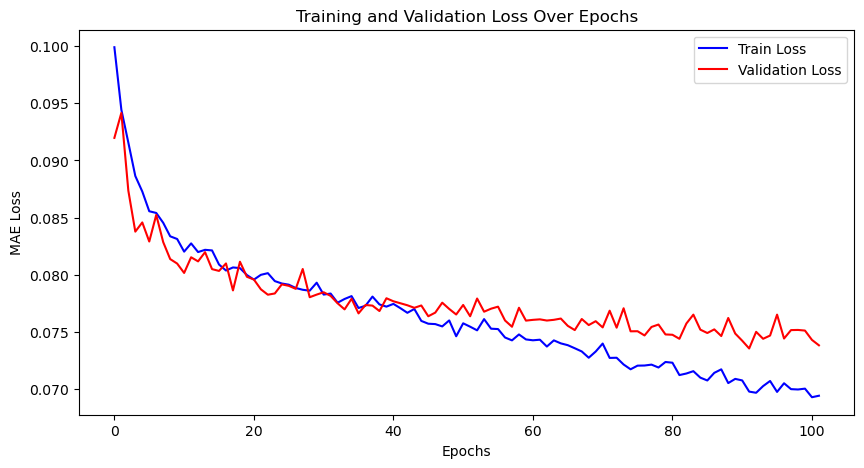

In [82]:

# import torch
# import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Ensure 'checkpoint_dir' is defined
checkpoint_dir = 'checkpoints_05'  # Update as needed
os.makedirs(checkpoint_dir, exist_ok=True)

# Check if a GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Set the number of epochs and early stopping parameters
num_epochs = 1000
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_data, batch_labels in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_data, val_labels in val_dataloader:
            val_data = val_data.to(device)
            val_labels = val_labels.to(device)

            outputs = model(val_data)
            loss = criterion(outputs, val_labels)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early Stopping and Checkpoint Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save only the model's state_dict
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_tempo_model.pth'))
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        counter = 0
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()


Step 8: Analyze the Learned Representations
8.1: Extract Latent Features from the training data

Mean Absolute Error in Tempo Estimation: 23.21 BPM


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_83794/2116281443.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

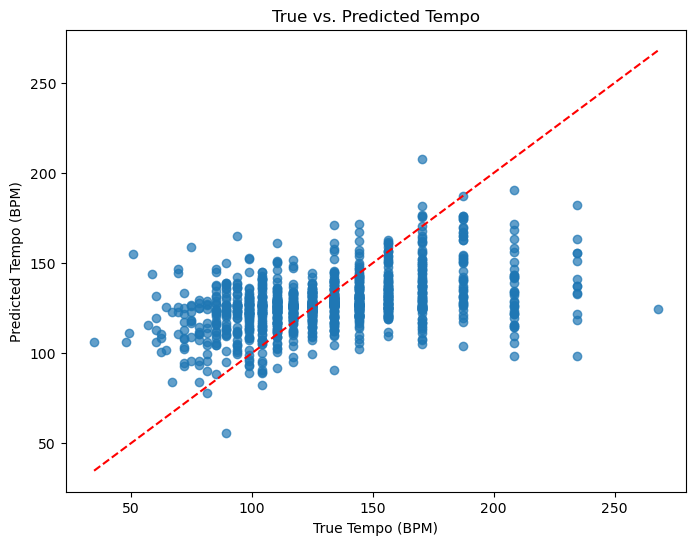

In [67]:
from sklearn.metrics import mean_absolute_error

# Load the best model from checkpoints_05
checkpoint_dir = 'checkpoints_05'  # Specify the directory where your model is saved
model_path = os.path.join(checkpoint_dir, 'best_tempo_model.pth')  # Adjust the filename if needed

# Load the model's state_dict
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

true_tempos = []
predicted_tempos = []

with torch.no_grad():
    for val_data, val_labels in val_dataloader:
        val_data = val_data.to(device)
        val_labels = val_labels.to(device)

        outputs = model(val_data)

        # Collect true and predicted tempos
        true_tempos.extend(val_labels.cpu().numpy())
        predicted_tempos.extend(outputs.cpu().numpy())

# Rescale predictions and true labels back to original tempo range
true_tempos_rescaled = [t * max_tempo for t in true_tempos]
predicted_tempos_rescaled = [p * max_tempo for p in predicted_tempos]

# Compute Mean Absolute Error
mae = mean_absolute_error(true_tempos_rescaled, predicted_tempos_rescaled)
print(f"Mean Absolute Error in Tempo Estimation: {mae:.2f} BPM")

# Plot true vs. predicted tempos
plt.figure(figsize=(8, 6))
plt.scatter(true_tempos_rescaled, predicted_tempos_rescaled, alpha=0.7)
plt.plot([min(true_tempos_rescaled), max(true_tempos_rescaled)],
         [min(true_tempos_rescaled), max(true_tempos_rescaled)], 'r--')
plt.xlabel('True Tempo (BPM)')
plt.ylabel('Predicted Tempo (BPM)')
plt.title('True vs. Predicted Tempo')
plt.show()


## Transform to ONNX

In [50]:
import torch
import onnx
import os

# Assuming the model has already been instantiated and is available as `model`
# Define the directory and file paths
checkpoint_dir = 'checkpoints_05'  # Directory to save/load the ONNX model
os.makedirs(checkpoint_dir, exist_ok=True)

# Load your trained model from the specified checkpoint directory
model_path = os.path.join(checkpoint_dir, 'best_tempo_model.pth')
onnx_model_path = os.path.join(checkpoint_dir, 'tempo_model.onnx')

# Load the state_dict into the existing model instance
model.load_state_dict(torch.load(model_path))
model.eval()

# Dummy input for the model (size should match the input size of your model)
dummy_input = torch.randn(1, model.fc1.in_features)  # `model.fc1.in_features` gets the input size

# Export the model to ONNX and save it in the specified directory
torch.onnx.export(model, dummy_input, onnx_model_path, opset_version=11)

print(f"ONNX model saved to {onnx_model_path}")


ONNX model saved to checkpoints_05/tempo_model.onnx


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_83794/224878899.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))